## Simple Testing of the ACO algorithm

In [3]:
%pip install --upgrade git+https://github.com/ovgu-FINken/python-experiment-runner.git

  Cloning https://github.com/ovgu-FINken/python-experiment-runner.git to /private/var/folders/f5/7kx8kghx2_722736y_vzg_cm0000gn/T/pip-req-build-vq6huvrd
  Running command git clone -q https://github.com/ovgu-FINken/python-experiment-runner.git /private/var/folders/f5/7kx8kghx2_722736y_vzg_cm0000gn/T/pip-req-build-vq6huvrd
  Found existing installation: ExperimentRunner 0.1.1
    Uninstalling ExperimentRunner-0.1.1:
      Successfully uninstalled ExperimentRunner-0.1.1
  Running setup.py install for ExperimentRunner ... done
Note: you may need to restart the kernel to use updated packages.


In [4]:
from src.aco_mapf.AcoAgent import AcoAgent, Colony
from src.aco_mapf.GraphWorld import GraphWorld, TestProblem
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from ExperimentRunner.ExperimentRunner import Experiment, Parameter
import ipyparallel as ipp
from IPython.display import display


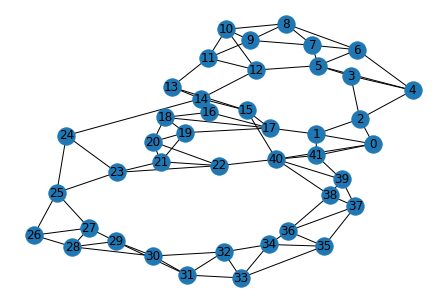

In [3]:
colony = Colony()
agents = [AcoAgent(seed=i, colony=colony, beta=0.02, eps=0.01, elitism_amount=0.05, c_d=0.05, c_t=0) for i in range(2)]
test1 = TestProblem(seed=42).hard_2(agents=agents)
test1.draw_adjacency()

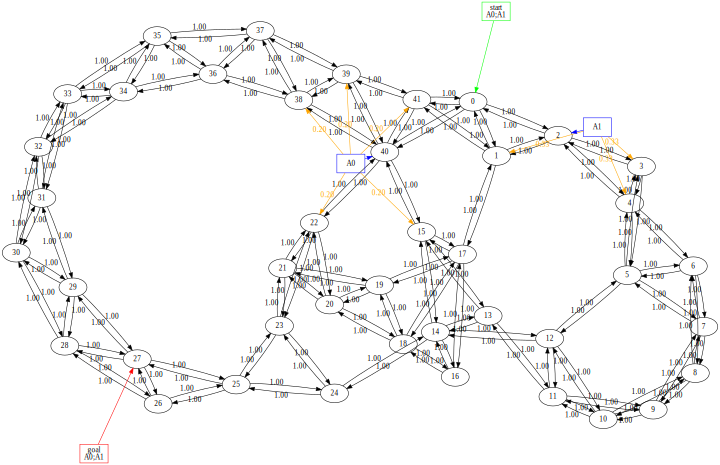

In [4]:
test1.step(c_d = 0.3, c_t = 0.3)
dot = test1.dot_graph(pheromones=colony.pheromones)
dot.attr(size="10,10")
display(dot)

In [5]:
for _ in range(100):
    test1.step()

In [3]:

@ipp.require("pandas as pd", "numpy as np", GraphWorld, TestProblem, AcoAgent, Colony)
def run_testprolem_aco(seed=0, num_agents=1,**kwargs):
    c = Colony()
    agents = [AcoAgent(seed=seed+offset, colony=c, **kwargs) for offset in range(num_agents)]
    problem = TestProblem(seed=seed).hard_1(agents=agents)
    data = []
    for _ in range(10):
        for _ in range(50):
            problem.step()
        data.append(problem.get_data())
    return pd.concat(data)


In [4]:
parameters = [
    Parameter(name="elitism_amount", default=0.05, space=np.logspace(-1, 1, num=5)),
    Parameter(name="alpha", default=1.0, space=np.logspace(-1, 1, num=5)),
    Parameter(name="beta", default=0.05, space=np.logspace(-1, 1, num=5)),
    Parameter(name="c_d", default=0.05, space=np.logspace(-1, 1, num=5)),
    Parameter(name="c_t", default=0.0),#, space=np.logspace(-1, 1, num=5)),
    Parameter(name="eps", default=0.003, space=np.logspace(-1, 1, num=5)),
    Parameter(name="num_agents", default=10)#, values=[1, 2, 5, 10, 20]),
             ]
experiment = Experiment(seed=1, function=run_testprolem_aco, parameters=parameters, runs=5)

/Users/sebastian/Software/MAPF/lib/python3.7/site-packages/ipyparallel/util.py:214: RuntimeWarning: IPython could not determine IPs for Sebastians-MacBook-Pro.local: [Errno 8] nodename nor servname provided, or not known
  RuntimeWarning)


In [8]:
experiment.tasks = []
experiment.function = run_testprolem_aco
experiment.generate_tasks()

In [16]:
df = experiment.run_map()

 105/105 tasks finished after  364 s
done


In [24]:
df = experiment.results

In [25]:
df = df.replace(np.inf, np.nan)
#df = df.set_index(["task_id"])
df['ratio'] = df["arrived"] / (df["stuck"] + df["arrived"])
df.head(20)

,agent_step_count,arrived,max_best_distance,median_best_distance,median_best_time,stuck,world_step_count,elitism_amount,alpha,beta,c_d,c_t,eps,num_agents,seed,task_time,task_id,ratio
0,500,2,26.325649,NaN,NaN,16,50,0.05,1.0,0.05,0.05,0.0,0.003,10,1791095845,0.009498,0,0.111111
0,1000,7,25.065829,52.282655,NaN,27,100,0.05,1.0,0.05,0.05,0.0,0.003,10,1791095845,0.009498,0,0.205882
0,1500,14,21.845684,29.251566,NaN,40,150,0.05,1.0,0.05,0.05,0.0,0.003,10,1791095845,0.009498,0,0.259259
0,2000,18,15.971760,27.683316,16.0,55,200,0.05,1.0,0.05,0.05,0.0,0.003,10,1791095845,0.009498,0,0.246575
0,2500,22,15.971760,26.942292,16.0,68,250,0.05,1.0,0.05,0.05,0.0,0.003,10,1791095845,0.009498,0,0.244444
0,3000,25,15.971760,26.584915,16.0,82,300,0.05,1.0,0.05,0.05,0.0,0.003,10,1791095845,0.009498,0,0.233645
0,3500,29,15.971760,26.584915,16.0,102,350,0.05,1.0,0.05,0.05,0.0,0.003,10,1791095845,0.009498,0,0.221374
0,4000,30,15.971760,26.584915,16.0,122,400,0.05,1.0,0.05,0.05,0.0,0.003,10,1791095845,0.009498,0,0.197368
0,4500,38,15.971760,25.904826,16.0,135,450,0.05,1.0,0.05,0.05,0.0,0.003,10,1791095845,0.009498,0,0.219653
0,5000,38,15.971760,25.904826,16.0,149,500,0.05,1.0,0.05,0.05,0.0,0.003,10,1791095845,0.009498,0,0.203209


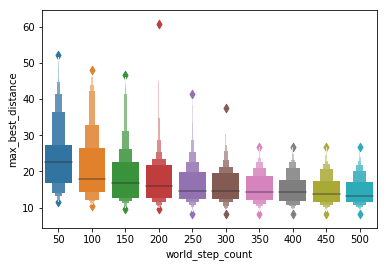

In [26]:
sns.boxenplot(data=df, x="world_step_count", y="max_best_distance")
plt.show()

In [27]:
experiment.save_results(filename="current.pkl")

In [7]:
def explore_parameter(data=None, parameters=None, name="Name"):
    df = data
    for parameter in parameters:
        if parameter.name != name and parameter.name in df.keys():
            df = df.loc[df[parameter.name] == parameter.default]
    return df

def plot_parameter(data=None, parameters=None, name="Name", y="collisions", **kwargs):
    df_eps_f = explore_parameter(data=data, parameters=parameters, name=name)
    sns.catplot(data=df_eps_f, x="world_step_count", y=y, col=name, sharex=True, sharey=True, **kwargs)#, kind="box")
    

In [8]:
for p in parameters:
    plot_parameter(data=df, parameters=parameters, name=p.name, y="median_best_distance", kind="box", legend=None)

NameError: name 'parameters' is not defined

In [17]:
len(df["seed"].unique())

105

   agent_step_count  arrived  max_best_distance  median_best_distance  \
0              2000       72           6.203262              6.356556   

   median_best_time  stuck  world_step_count  
0                 7     70              1000  


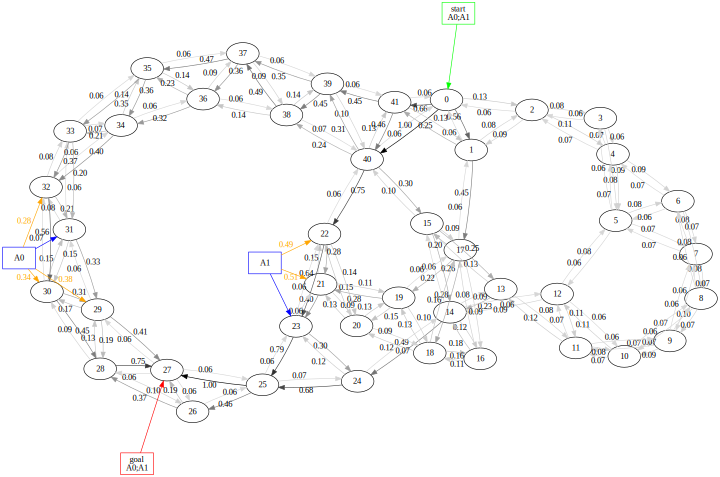

In [18]:
world = TestProblem(seed=43).hard_2()
colony1 = Colony()
colony2 = Colony()
colony3 = Colony()
agents = [AcoAgent(colony=colony1, start=world.agents[0].start, goal=world.agents[0].goal, seed=seed) for seed in range(2)]
#agents += [AcoAgent(colony=colony2, start=10, goal=20, seed=seed) for seed in range(2)]
#agents += [AcoAgent(colony=colony3, start=20, goal=30, seed=seed) for seed in range(2)]
world.update_agents(agents)
for _ in range(1000):
    world.step(c_t = 0.1, c_d = 0.1, eps=0.01)
#print(f"{colony.pheromones}")
print(world.get_data())
dot = world.dot_graph(colony1.pheromones)
dot.attr(size="10,10")
display(dot)

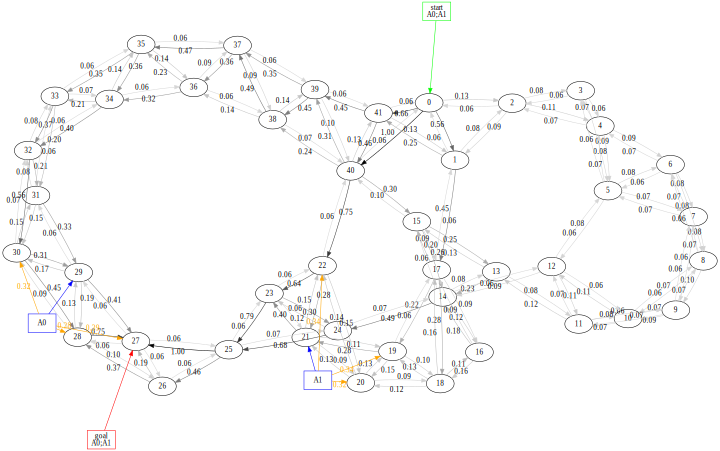

In [19]:
world.step()
dot = world.dot_graph(colony1.pheromones)
dot.attr(size="10,10")
display(dot)

   agent_step_count  arrived  max_best_distance  median_best_distance  \
0              6000      208           4.880533              5.807885   

   median_best_time  stuck  world_step_count  
0                 6    194              1000  


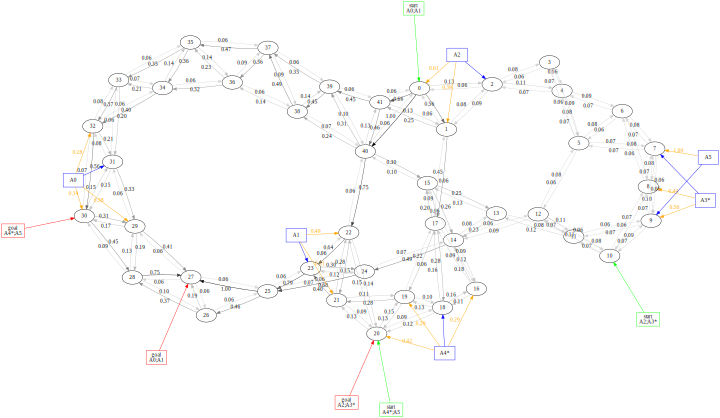

In [20]:
world = TestProblem(seed=43).hard_2()
colony1 = Colony()
colony2 = Colony()
colony3 = Colony()
agents = [AcoAgent(colony=colony1, start=world.agents[0].start, goal=world.agents[0].goal, seed=seed) for seed in range(2)]
agents += [AcoAgent(colony=colony2, start=10, goal=20, seed=seed) for seed in range(2)]
agents += [AcoAgent(colony=colony3, start=20, goal=30, seed=seed) for seed in range(2)]
world.update_agents(agents)
for _ in range(1000):
    world.step(c_t = 0.1, c_d = 0.1)
#print(f"{colony.pheromones}")
print(world.get_data())
dot = world.dot_graph(colony1.pheromones)
dot.attr(size="10,10")
display(dot)

In [29]:
remote_parameters = [
    Parameter(name="elitism_amount", default=0.05, space=np.logspace(-2, 2, num=7)),
    Parameter(name="alpha", default=1.0, space=np.logspace(-1, 1, num=7)),
    Parameter(name="beta", default=0.05, space=np.logspace(-1, 1, num=7)),
    Parameter(name="c_d", default=0.05, space=np.logspace(-1, 1, num=7)),
    Parameter(name="c_t", default=0.0, values = np.logspace(-2, 2, num=7)*0.01),
    Parameter(name="eps", default=0.003, space=np.logspace(-1.5, 1.5, num=7)),
    Parameter(name="num_agents", default=10, values=[1, 2, 5, 10, 20]),
    Parameter(name="log_steps", default=100),
    Parameter(name="between_log_steps", default=10)
]
e = Experiment(with_cluster=False, parameters=remote_parameters)
e.save_parameters("test.json")

In [30]:
remote = Experiment(with_cluster=False)
remote.load_parameters("test.json")
params = remote.parameters
df = remote.load_results("test.pkl")
df = df.replace(np.inf, np.nan)
df['ratio'] = df["arrived"] / (df["stuck"] + df["arrived"])
df.loc[df["world_step_count"]==50].head(50)

,agent_step_count,arrived,max_best_distance,median_best_distance,median_best_time,stuck,world_step_count,elitism_amount,alpha,beta,c_d,c_t,eps,num_agents,seed,task_time,task_id,ratio
0,500,1,34.922565,NaN,NaN,17,50,0.050000,1.0,0.05,0.05,0.0,0.003,10,3136364041,0.003637,0,0.055556
0,500,1,32.254467,NaN,NaN,14,50,0.050000,1.0,0.05,0.05,0.0,0.003,10,127122816,0.003570,1,0.066667
0,500,0,NaN,NaN,NaN,17,50,0.050000,1.0,0.05,0.05,0.0,0.003,10,3673235751,0.003529,2,0.000000
0,500,0,NaN,NaN,NaN,21,50,0.050000,1.0,0.05,0.05,0.0,0.003,10,3380387564,0.003560,3,0.000000
0,500,5,13.585437,NaN,NaN,13,50,0.050000,1.0,0.05,0.05,0.0,0.003,10,1389246632,0.003606,4,0.277778
0,500,1,28.052414,NaN,NaN,19,50,0.050000,1.0,0.05,0.05,0.0,0.003,10,2171514588,0.003540,5,0.050000
0,500,0,NaN,NaN,NaN,17,50,0.050000,1.0,0.05,0.05,0.0,0.003,10,2674431686,0.003613,6,0.000000
0,500,1,24.359946,NaN,NaN,8,50,0.050000,1.0,0.05,0.05,0.0,0.003,10,4068416044,0.003545,7,0.111111
0,500,2,24.810012,NaN,NaN,19,50,0.050000,1.0,0.05,0.05,0.0,0.003,10,3078143781,0.003623,8,0.095238
0,500,2,26.046423,NaN,NaN,15,50,0.050000,1.0,0.05,0.05,0.0,0.003,10,2305397661,0.003637,9,0.117647


KeyError: 'log_steps'

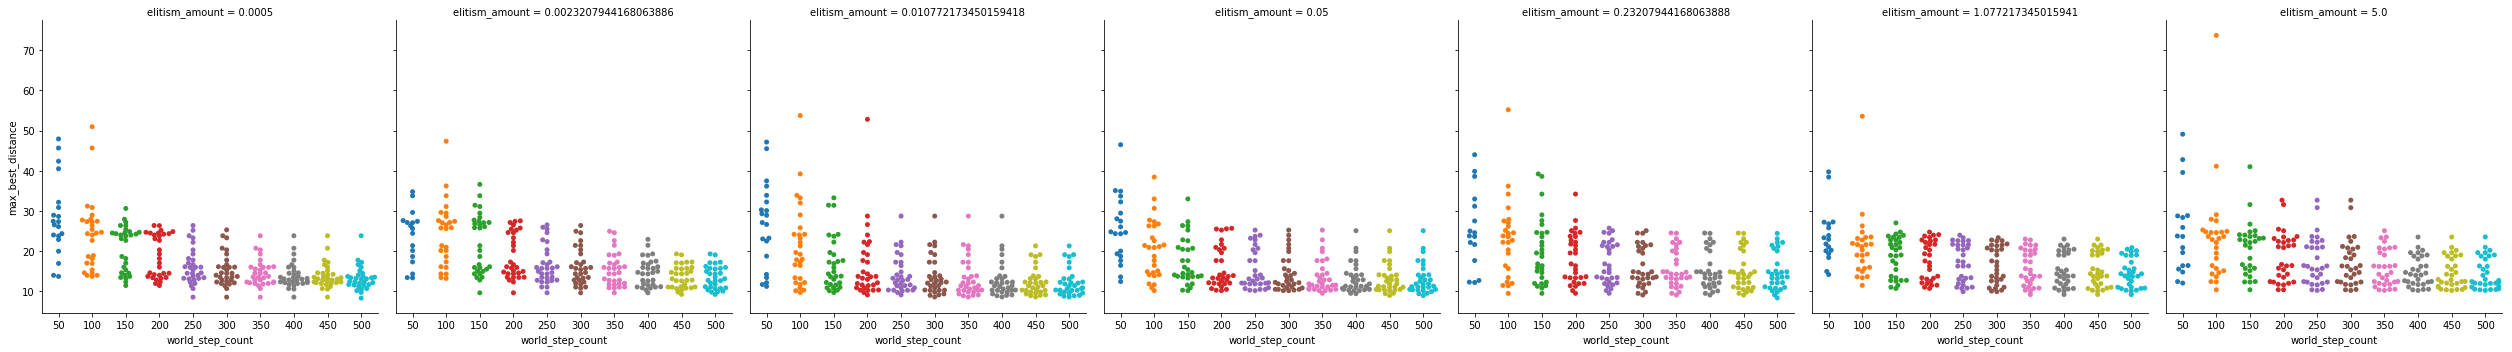

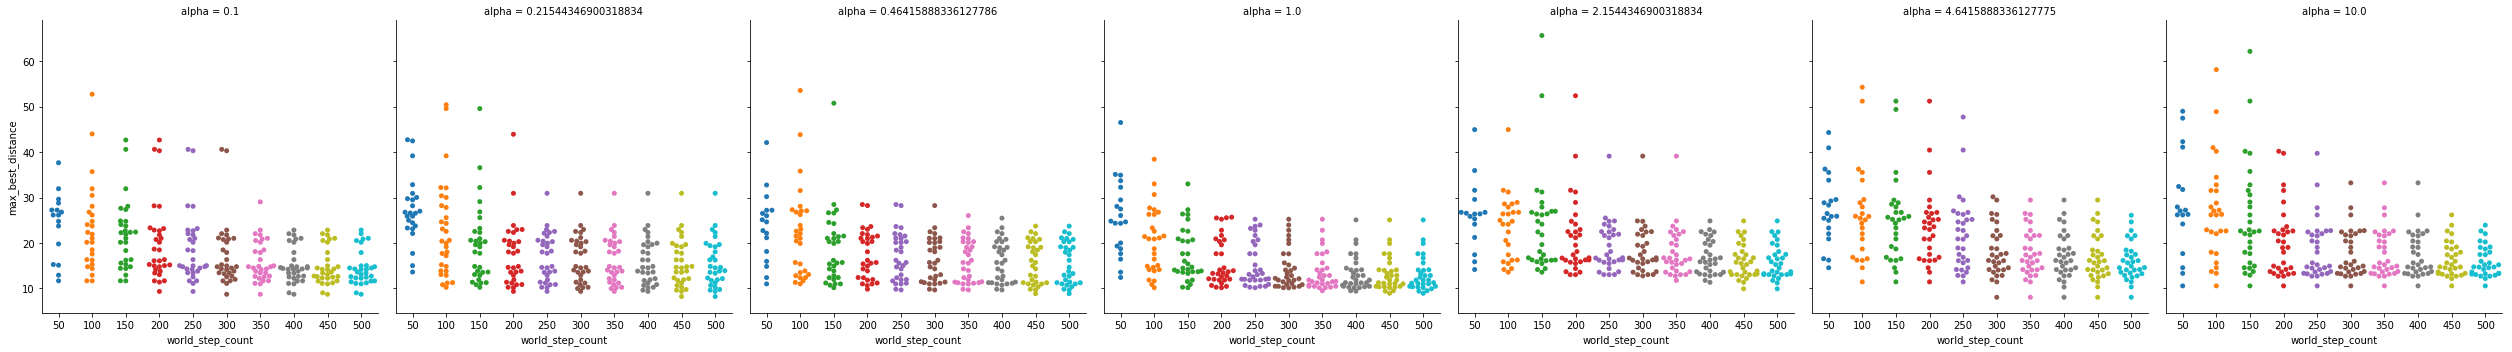

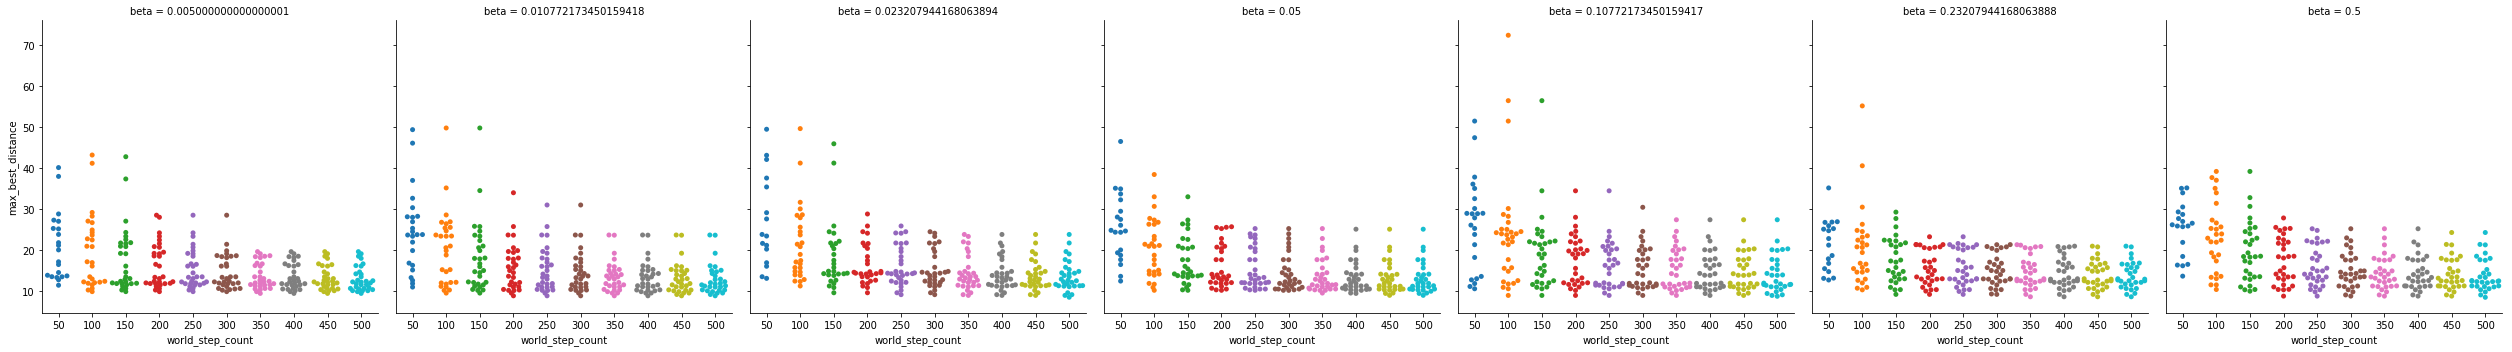

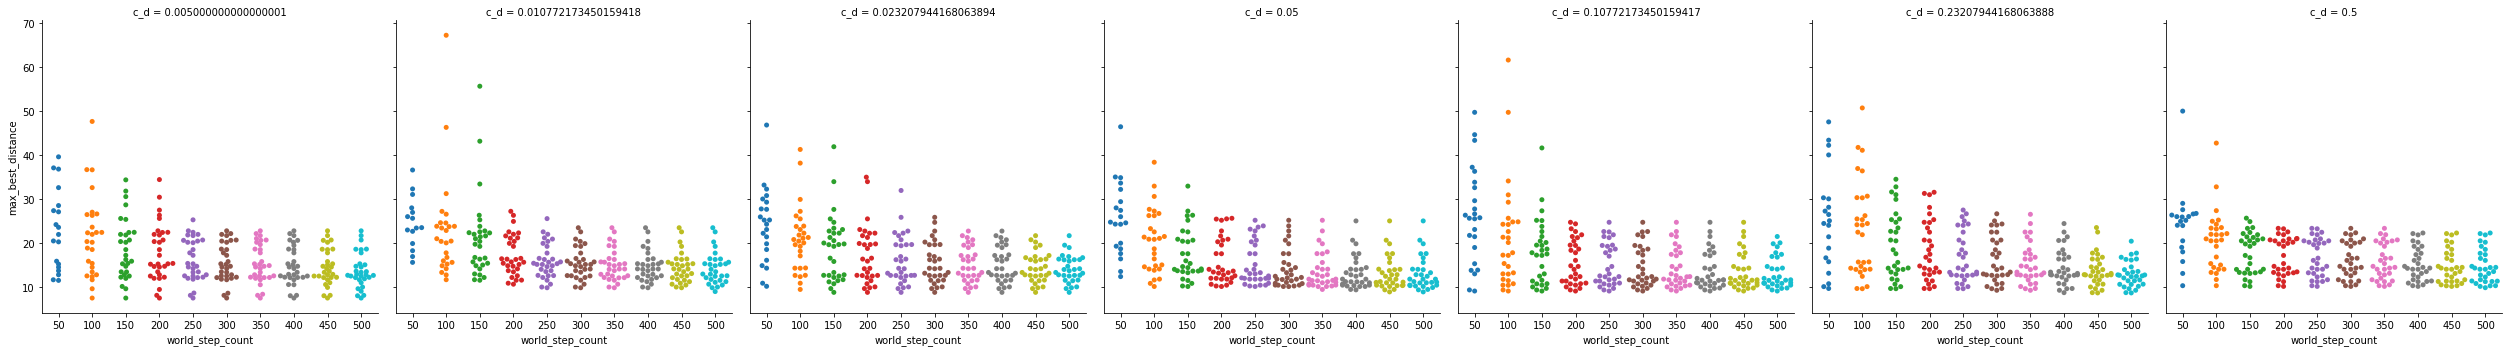

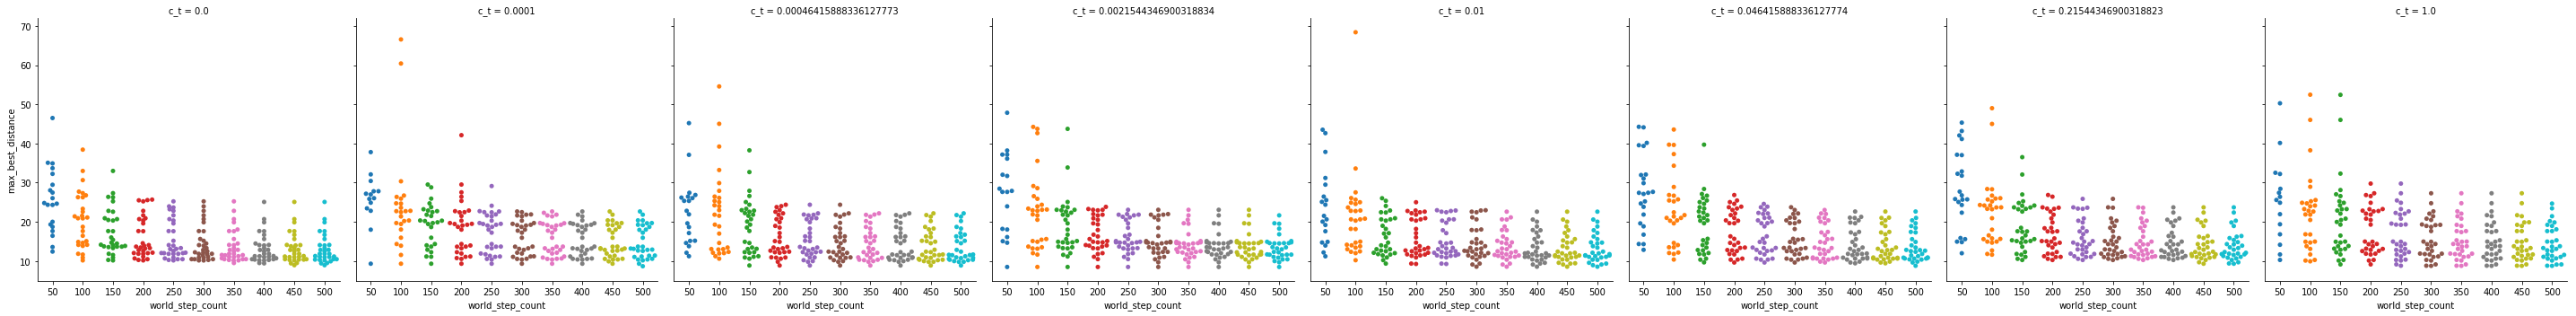

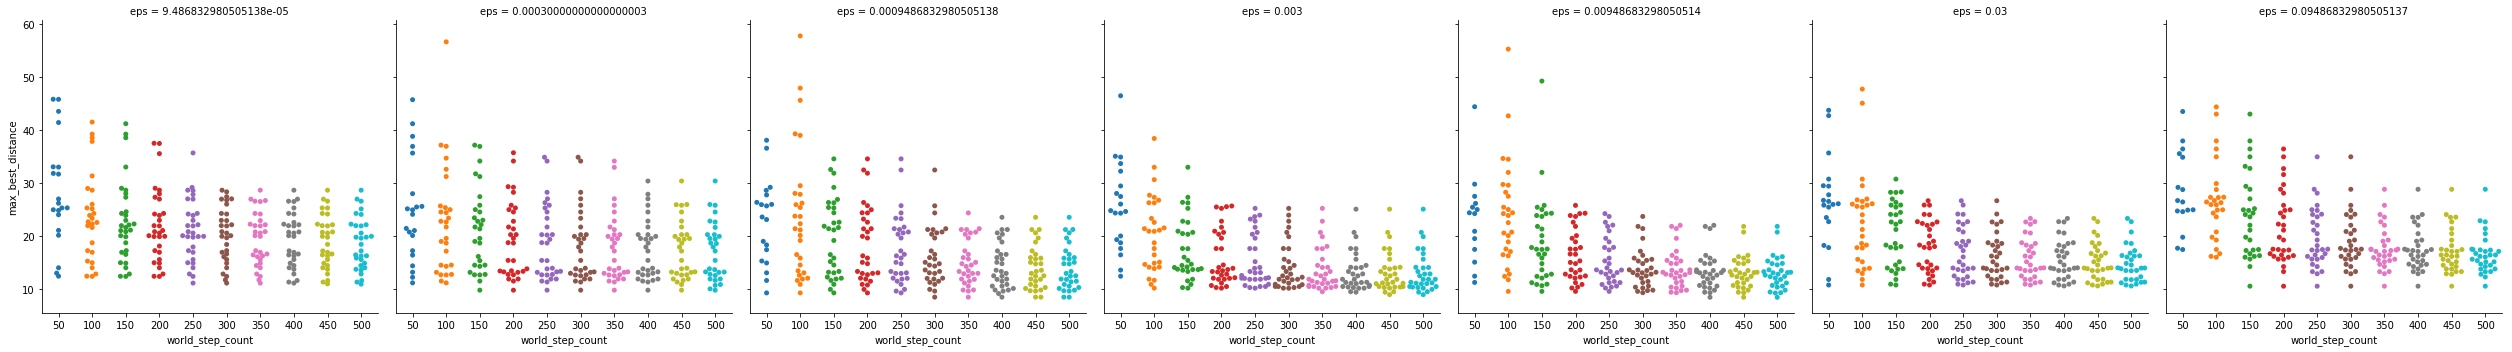

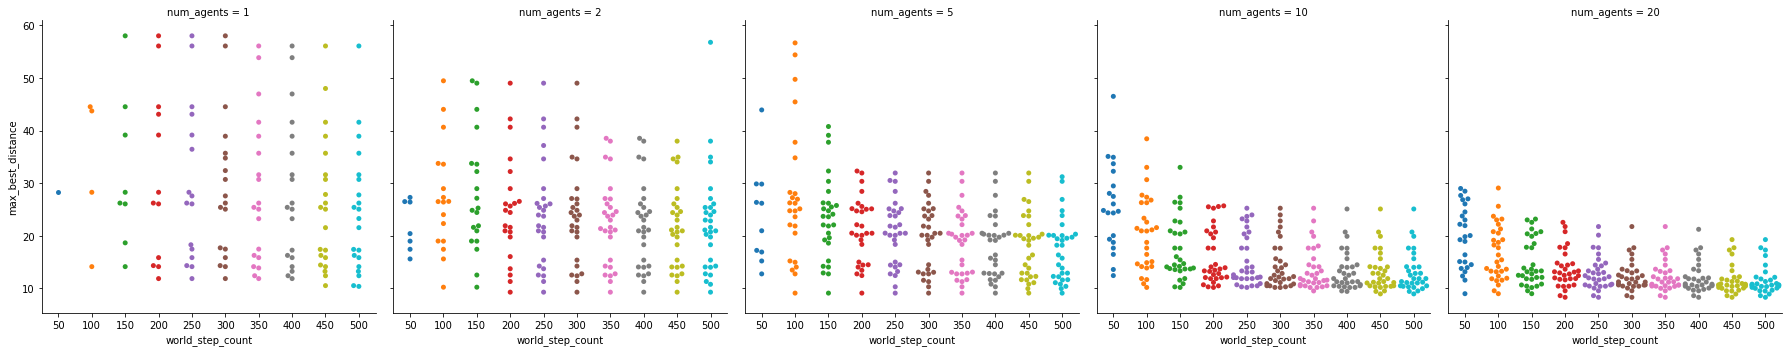

In [31]:
for p in params:
    plot_parameter(data=df, parameters=params, name=p.name, y="max_best_distance", kind="swarm", legend=None)